In [1]:
import pyro
import numpy as np                                                                                                                                                   
import torch
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import model_selection
import pyro.distributions as pdist
import pyro.contrib.gp as gp
import torch.distributions as tdist
import torch.nn as tnn
import pyro.nn as pnn
import arviz
import math

In [33]:
#g(x)=-(sin(6pix))^2+6x^2-5x^4+3/2
def func(X):
    return -torch.sin(6*math.pi*X)**2+6*X**2-5*X**4+3/2

In [34]:
# Data
X = torch.tensor(np.linspace(0, 1, 30))
y = func(X)

In [35]:
# Define Model
kernel = gp.kernels.RBF(input_dim=1)
kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(-1,1))
kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0,2))
gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(1e-4))

In [36]:
# NUTS to sample from posterior
nuts_kernel = pyro.infer.NUTS(gpr.model)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=500, num_chains=2, warmup_steps=5) #tuning for warmup_steps
mcmc.run()

Warmup [1]:   0%|          | 0/505 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/505 [00:00, ?it/s]

                     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.071  0.020   0.011    0.088      0.010    0.009   
kernel.variance     3.681  2.539   1.377    8.022      1.546    1.240   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale       3.0      13.0   2.20  
kernel.variance          3.0       3.0   2.04  


D:\ArcGIS Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arviz\data\io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

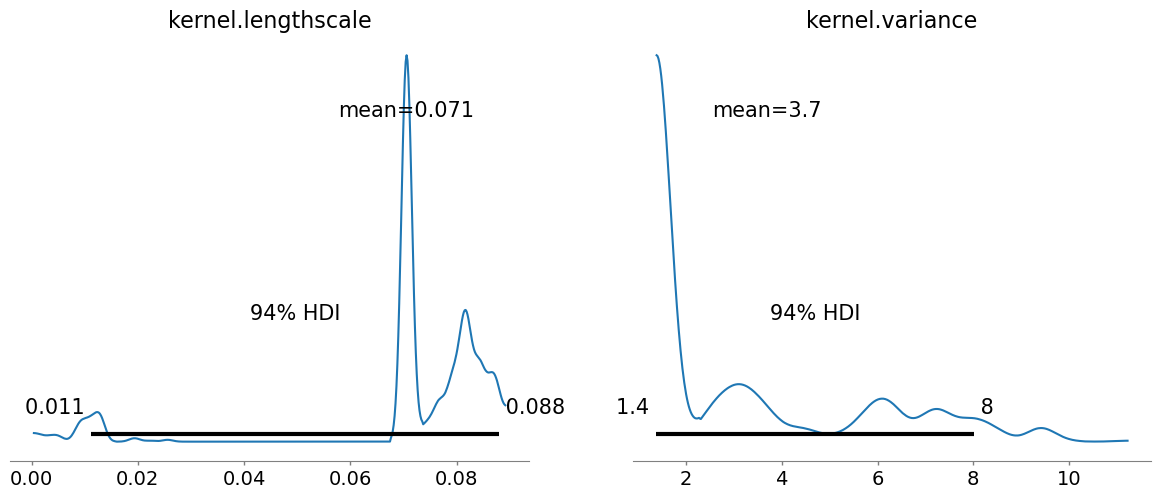

In [37]:
# diagnostics to choose hyperparameters of the sampling
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data)
print(summary)
arviz.plot_posterior(data)

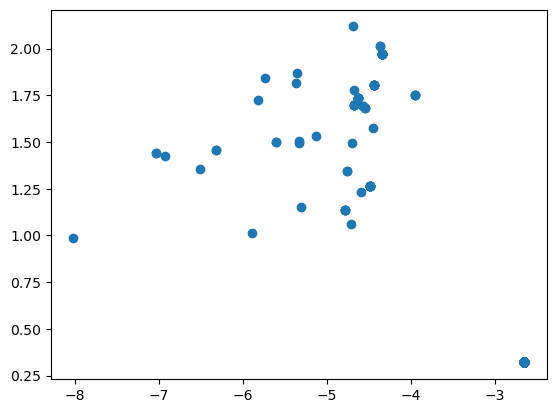

In [38]:
# scattor plot of samples from posterior
ls = mcmc.get_samples()['kernel.lengthscale'][:500]
var = mcmc.get_samples()['kernel.variance'][:500]
plt.scatter(torch.log(ls), torch.log(var))

In [39]:
## estimate new point
Xnew = torch.linspace(-1,1,200)
Xnew = Xnew.to(torch.double)
f_loc, f_cov = gpr(Xnew, full_cov = False)

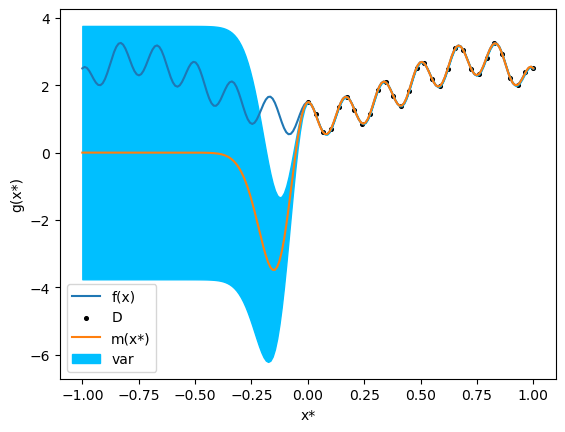

In [44]:
plt.plot(Xnew, func(Xnew),label = 'f(x)')
plt.scatter(X,y,label = 'D',color='black', s=7)
plt.plot(Xnew, f_loc.detach().numpy(), label='m(x*)')
plt.fill_between(Xnew, f_loc.detach().numpy()+2*(f_cov.sqrt()).detach().numpy(), f_loc.detach().numpy()-2*(f_cov.sqrt()).detach().numpy(),color="deepskyblue",label='var')
plt.xlabel("x*")
plt.ylabel("g(x*)")
plt.legend()